# 🧠 AI Agent: Text Classification using DistilBERT

## 🗂️ Overview
This module aims to build an AI agent capable of classifying text data using a pre-trained DistilBERT model (`distilbert/distilbert-base-uncased-finetuned-sst-2-english`). The pipeline will include data loading, preprocessing, model inference, and result visualization.

---

## 0. Load Libraries


In [31]:
# 📁 Data Handling and Preprocessing
import pandas as pd
import numpy as np
import re
import string

# 🔍 Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# 🤗 Hugging Face Transformers
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import pipeline

# 🧠 PyTorch for Model Inference
import torch
from torch.utils.data import Dataset, DataLoader

# 🧪 Evaluation Metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 🌐 Optional: Interface
# CLI / App-based interface (for optional user interaction)
# import gradio as gr      # for building simple web UIs
# import streamlit as st   # for dashboard-like interface
# import argparse          # for CLI if needed
# 📂 Google Drive Integration (if using Colab)
from google.colab import drive

# 🐍 System and Utilities
import os
import random
import warnings
warnings.filterwarnings("ignore")


## 📁 1. Data Preparation

### 1.1 Load Dataset from Google Drive


In [32]:
df = pd.read_csv("/content/drive/MyDrive/NLP_Projects/BBC_News_Text_Classification/bbc_data.csv")

In [33]:
df.sample(10)

,data,labels
594,Newest EU members underpin growth The Europea...,business
1259,Liverpool pledge to keep Gerrard Liverpool ch...,sport
1695,Election could be terror target Terrorists mi...,politics
1120,Kenya lift Chepkemeis suspension Kenyas athle...,sport
683,Soaring oil hits world economy The soaring co...,business
1026,Dallaglio his own man to the end Controversy ...,sport
1069,Mutu to hold talks with Juventus Disgraced fo...,sport
814,US economy shows solid GDP growth The US econ...,business
781,Q&A: Malcolm Glazer and Man Utd The battle fo...,business
2221,Fast lifts rise into record books Two high-sp...,tech


In [42]:
df['labels'].unique()

array(['entertainment', 'business', 'sport', 'politics', 'tech'],
      dtype=object)

In [34]:
df.tail(5)

,data,labels
2220,Warning over Windows Word files Writing a Mic...,tech
2221,Fast lifts rise into record books Two high-sp...,tech
2222,Nintendo adds media playing to DS Nintendo is...,tech
2223,Fast moving phone viruses appear Security fir...,tech
2224,Hacker threat to Apples iTunes Users of Apple...,tech


In [35]:
df.head(5)

,data,labels
0,Musicians to tackle US red tape Musicians gro...,entertainment
1,"U2s desire to be number one U2, who have won ...",entertainment
2,Rocker Doherty in on-stage fight Rock singer ...,entertainment
3,Snicket tops US box office chart The film ada...,entertainment
4,"Oceans Twelve raids box office Oceans Twelve,...",entertainment


### 1.2 Inspect and Understand the Data
- Check for null values, class balance, and structure
- Preview sample texts and labels

In [36]:
# Check for null values
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values)

Missing values per column:
 data      0
labels    0
dtype: int64


In [37]:
# Check data types and structure
print("\nData types:\n", df.dtypes)
print("\nDataFrame shape:", df.shape)


Data types:
 data      object
labels    object
dtype: object

DataFrame shape: (2225, 2)


In [39]:
# Check class balance
print("\nClass distribution:\n", df['labels'].value_counts())

# Preview sample texts and labels (already done in previous cells)


Class distribution:
 labels
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64


In [43]:
df.isna().sum()

,0
data,0
labels,0


### 1.3 Clean and Preprocess Text
- Remove noise (HTML, emojis, special characters)
- Normalize case
- Optional: Remove stopwords, perform lemmatization

In [51]:
df.head(2)

,data,labels
0,Musicians to tackle US red tape Musicians gro...,entertainment
1,"U2s desire to be number one U2, who have won ...",entertainment


In [53]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Initialize Lemmatizer and Stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove emojis (basic regex, might not catch all)
    text = re.sub(r'[^\w\s#@/:%.\-]+', '', text, flags=re.UNICODE)
    # Remove special characters and punctuation
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def preprocess_text(text):
    # Apply cleaning
    text = clean_text(text)
    # Tokenize (split into words)
    tokens = text.split()
    # Remove stopwords and lemmatize
    processed_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    # Join tokens back into a string
    return ' '.join(processed_tokens)

# Apply the preprocessing function to the 'text' column
df['cleaned_text'] = df['data'].apply(preprocess_text)

# Display the first few rows with the new cleaned_text column
print(df[['data', 'cleaned_text']].head())

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                                data  \
0  Musicians to tackle US red tape  Musicians gro...   
1  U2s desire to be number one  U2, who have won ...   
2  Rocker Doherty in on-stage fight  Rock singer ...   
3  Snicket tops US box office chart  The film ada...   
4  Oceans Twelve raids box office  Oceans Twelve,...   

                                        cleaned_text  
0  musician tackle u red tape musician group tack...  
1  u2s desire number one u2 three prestigious gra...  
2  rocker doherty onstage fight rock singer pete ...  
3  snicket top u box office chart film adaptation...  
4  ocean twelve raid box office ocean twelve crim...  


In [54]:
df.sample(10)

,data,labels,cleaned_text
1129,Jones doping probe begins An investigation in...,sport,jones doping probe begin investigation doping ...
1713,Civil servants in strike ballot The UKs bigge...,politics,civil servant strike ballot uk biggest civil s...
264,Halloween writer Debra Hill dies Screenwriter...,entertainment,halloween writer debra hill dy screenwriter pr...
1621,Profile: David Miliband David Milibands rapid...,politics,profile david miliband david milibands rapid r...
518,US consumer confidence up Consumers confidenc...,business,u consumer confidence consumer confidence stat...
1669,"Analysis: No pain, no gain? He called it his ...",politics,analysis pain gain called masochism strategy r...
806,"Diageo to buy US wine firm Diageo, the worlds...",business,diageo buy u wine firm diageo world biggest sp...
1275,Clijsters could play Aussie Open Kim Clijster...,sport,clijsters could play aussie open kim clijsters...
979,Wright-Phillips to start on right England coa...,sport,wrightphillips start right england coach sveng...
1384,Hingis hints at playing comeback Martina Hing...,sport,hingis hint playing comeback martina hingis ad...


In [56]:
# Further preprocessing steps
# 1. Handle potential empty strings after preprocessing
df['cleaned_text'] = df['cleaned_text'].replace('', np.nan)
df.dropna(subset=['cleaned_text'], inplace=True)


Distribution of text lengths:
count    2225.000000
mean      222.863371
std       127.676518
min        49.000000
25%       145.000000
50%       197.000000
75%       273.000000
max      2237.000000
Name: text_length, dtype: float64


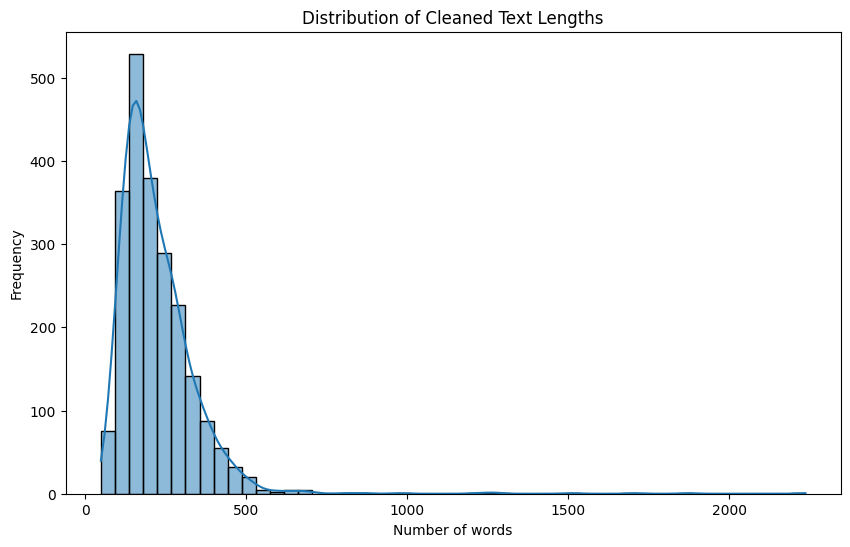

In [57]:
# 2. Check for distribution of text lengths
df['text_length'] = df['cleaned_text'].apply(lambda x: len(x.split()))
print("\nDistribution of text lengths:")
print(df['text_length'].describe())

# Optional: Visualize text length distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], bins=50, kde=True)
plt.title('Distribution of Cleaned Text Lengths')
plt.xlabel('Number of words')
plt.ylabel('Frequency')
plt.show()



In [58]:
# Optional: Remove very short
# Example: Remove texts shorter than 5 words (arbitrary threshold)
# df = df[df['text_length'] >= ].reset_index(drop=True)
# print(f"\nShape after removing short texts: {df.shape}")


Shape after removing short texts: (2225, 5)


In [59]:

# 3. Re-check class distribution after dropping rows
print("\nClass distribution after preprocessing:")
print(df['labels'].value_counts())




Class distribution after preprocessing:
labels
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64


In [60]:
# 4. Map labels to integers if needed for model training (DistilBERT fine-tuning typically requires integer labels)
# Create a mapping from label string to integer
label_map = {label: i for i, label in enumerate(df['labels'].unique())}
df['label_id'] = df['labels'].map(label_map)
print("\nLabel mapping:", label_map)
print("\nDataFrame with label_id:")
print(df[['labels', 'label_id', 'cleaned_text']].head())



Label mapping: {'entertainment': 0, 'business': 1, 'sport': 2, 'politics': 3, 'tech': 4}

DataFrame with label_id:
          labels  label_id                                       cleaned_text
0  entertainment         0  musician tackle u red tape musician group tack...
1  entertainment         0  u2s desire number one u2 three prestigious gra...
2  entertainment         0  rocker doherty onstage fight rock singer pete ...
3  entertainment         0  snicket top u box office chart film adaptation...
4  entertainment         0  ocean twelve raid box office ocean twelve crim...


In [61]:

# 5. Display final preprocessed data sample
print("\nFinal preprocessed data sample:")
print(df[['label_id', 'cleaned_text']].sample(5))


Final preprocessed data sample:
      label_id                                       cleaned_text
1162         2  desailly back blue revenge trip marcel desaill...
40           0  oscar nominee dan oherlihy dy irish actor dan ...
1226         2  hereford 11 doncaster hereford win 31 penalty ...
1185         2  mourinho expects fight finish chelsea manager ...
1625         3  clarke defends terror detention home secretary...


In [62]:
df.sample(5)

,data,labels,cleaned_text,text_length,label_id
701,UK bank seals South Korean deal UK-based bank...,business,uk bank seal south korean deal ukbased bank st...,417,1
545,UK interest rates held at 4.75% The Bank of E...,business,uk interest rate held 475 bank england left in...,306,1
282,Foxx and Swank take actors awards Jamie Foxx ...,entertainment,foxx swank take actor award jamie foxx hilary ...,206,0
1150,Brentford v Southampton Griffin Park Tuesday...,sport,brentford v southampton griffin park tuesday 1...,401,2
1568,Crucial decision on super-casinos A decision ...,politics,crucial decision supercasinos decision whether...,103,3


## 🤗 2. Model Setup: Hugging Face Transformers

### 2.1 Load Pre-trained DistilBERT
- Use `distilbert/distilbert-base-uncased-finetuned-sst-2-english` for binary sentiment classification

### 2.2 Tokenize the Input Data
- Utilize `DistilBertTokenizer`
- Pad and truncate sequences to a consistent length
- Convert tokens to tensor format

---


## 🧪 3. Model Inference

### 3.1 Create a DataLoader (if batch processing)
- Tokenized inputs and attention masks
- Define batch size and enable shuffling for better randomness

### 3.2 Perform Inference
- Use the DistilBERT model in evaluation mode
- Predict logits and convert them to class labels

---

## 📊 4. Evaluation and Metrics

### 4.1 Evaluate Model Performance
- Use accuracy, precision, recall, F1-score
- Generate classification report and confusion matrix

### 4.2 Visualize Results
- Bar plots for class distribution
- Confusion matrix heatmap

---


## 🧠 5. AI Agent Wrapping

### 5.1 Define a Predict Function
- Input: Raw text
- Output: Predicted class label (e.g., positive/negative)

### 5.2 Build a CLI or Web Interface (Optional)
- CLI: Use `argparse` or similar
- Web: Use Gradio or Streamlit for a user-friendly UI

---

## 🧪 6. Testing and Validation

### 6.1 Run End-to-End Test
- Load raw input, run through model, verify output

### 6.2 Error Analysis
- Identify and analyze misclassified examples

---




## 🚀 7. Deployment (Optional)

### 7.1 Save the Model and Tokenizer
- Use `save_pretrained` for persistence

### 7.2 Deploy as API
- Use FastAPI or Flask for serving
- Dockerize for scalability if needed

---


## ✅ 8. Final Notes

- Ensure reproducibility (random seeds, version logging)
- Document each component for maintainability
- Track experiments and results (e.g., with MLflow or Weights & Biases)

